In [161]:
import numpy as np
import netCDF4 as ncdf
import matplotlib as mlab
import matplotlib.pyplot as plt
import xarray as xr
import glob as glob
import os as os
import sys as sys
from filter import raymond_lowpass 


# These are 45 vertical levels that the FV3 puts out - use them here to map ARW to that grid for comparison

plevels = np.asarray([100000.,  97500.,  95000.,  92500.,  90000.,  87500.,  85000.,  82500.,
                       80000.,  77500.,  75000.,  72500.,  70000.,  67500.,  65000.,  62500.,
                       60000.,  57500.,  55000.,  52500.,  50000.,  47500.,  45000.,  42500.,
                       40000.,  37500.,  35000.,  32500.,  30000.,  27500.,  25000.,  22500.,
                       20000.,  17500.,  15000.,  12500.,  10000.,   7000.,   5000.,   3000.,
                        2000.,   1000.,    700.,    500.,    200.])
nz_new = plevels.shape[0]

vmin = -5.
vmax = 10.

clevels = np.linspace(vmin, vmax, 31)
print(clevels)

klevel = 30
plevel = plevels[klevel]

utc = 21

def title_string(time, pres, label, wmax, wmin, eps=None):
    if eps:
        return ("%2.2i UTC %s at Pres=%3.0f mb with EPS=%5.1f \n Wmax: %3.1f        Wmin: %4.2f" % (time, label, pres/100., eps, wmax, wmin))
    else:
        return ("%2.2i UTC %s at Pres=%3.0f mb \n Wmax: %3.1f        Wmin: %4.2f" % (time, label, pres/100., wmax, wmin))

[-5.  -4.5 -4.  -3.5 -3.  -2.5 -2.  -1.5 -1.  -0.5  0.   0.5  1.   1.5
  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5  7.   7.5  8.   8.5
  9.   9.5 10. ]


In [162]:
f = xr.open_dataset(("/Users/Louis.Wicker/04May2021_HRRR/region.20210504_conus_hrrr.t00z.wrfnatf%2.2i.nc4" % utc))
print(f)

g = xr.open_dataset("/Users/Louis.Wicker/04May2021_RRFS/mem1/region.t00z.mem01.naf%3.3i.nc4" % utc)
print(g)



<xarray.Dataset>
Dimensions:  (ny: 434, nx: 523, nz: 45)
Coordinates:
    lats     (ny, nx) float32 ...
    lons     (ny, nx) float32 ...
    pres     (nz) float64 ...
Dimensions without coordinates: ny, nx, nz
Data variables:
    W        (nz, ny, nx) float32 ...
    HGT      (nz, ny, nx) float32 ...
    TEMP     (nz, ny, nx) float32 ...
    U        (nz, ny, nx) float32 ...
    V        (nz, ny, nx) float32 ...
    CREF     (ny, nx) float32 ...
    UH       (ny, nx) float32 ...
    plevels  (nz) float64 ...
    SFC_HGT  (ny, nx) float32 ...
<xarray.Dataset>
Dimensions:  (nz: 45, ny: 556, nx: 641)
Coordinates:
    lats     (ny, nx) float32 ...
    lons     (ny, nx) float32 ...
    pres     (nz) float64 ...
Dimensions without coordinates: nz, ny, nx
Data variables:
    HGT      (nz, ny, nx) float32 ...
    W        (nz, ny, nx) float32 ...
    TEMP     (nz, ny, nx) float32 ...
    U        (nz, ny, nx) float32 ...
    V        (nz, ny, nx) float32 ...
    CREF     (ny, nx) float32 ...


In [163]:
fw_tmp = np.nan_to_num((f.W.values).astype('float64'))
fw_tmp2 = np.nan_to_num((f.W.values).astype('float64'))
f.variables['W'][...] = np.nan_to_num(f.W)

gw_tmp = np.nan_to_num((g.W.values).astype('float64'))
gw_tmp2 = np.nan_to_num((g.W.values).astype('float64'))

g.variables['W'][...] = np.nan_to_num(g.W)


In [164]:
eps = 100.

for k in np.arange(fw_tmp.shape[0]):
    fw_tmp2[k] = fw_tmp[k] - xr.DataArray(raymond_lowpass.raymond2d_lowpass(fw_tmp[k].transpose(),eps).transpose())

fw_tmp2 = f.W.copy(data=fw_tmp2)

#

for k in np.arange(gw_tmp.shape[0]):
    gw_tmp2[k] = gw_tmp[k] - xr.DataArray(raymond_lowpass.raymond2d_lowpass(gw_tmp[k].transpose(),eps).transpose())

gw_tmp2 = g.W.copy(data=gw_tmp2)


Text(0.5, 1.0, '21 UTC RRFS-mem1 High Pass Filter W at Pres=250 mb with EPS=100.0 \n Wmax: 11.0        Wmin: -6.16')

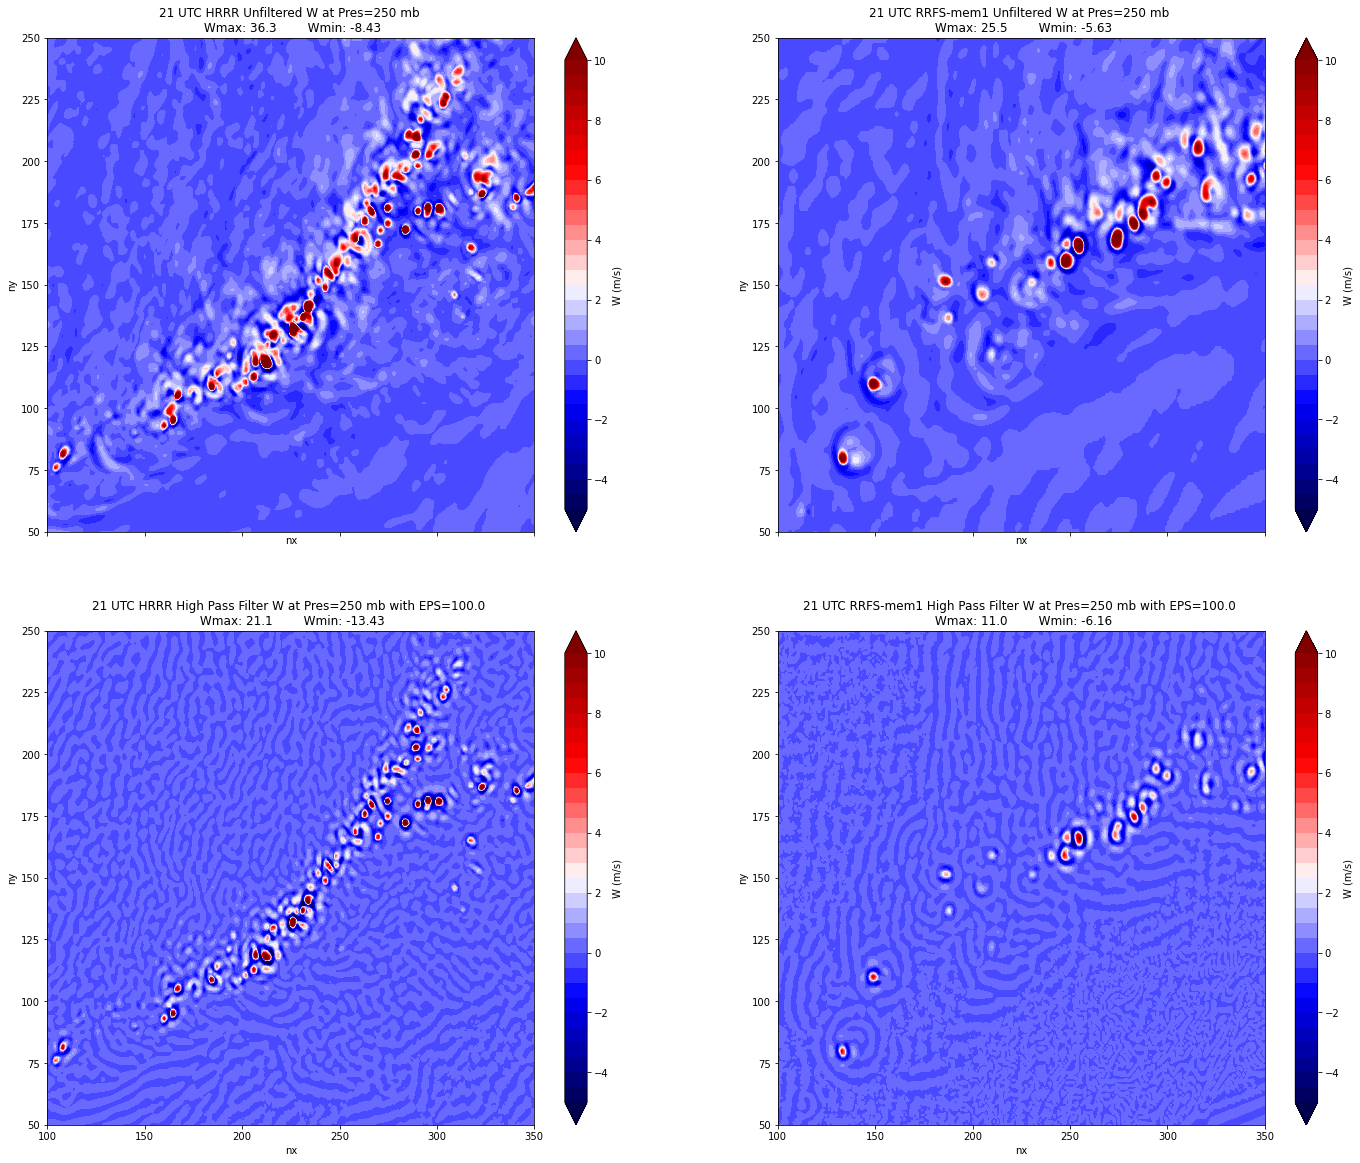

In [168]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(24,20), sharex=True)

# Plot the HRRR data

f.W.isel(nz=klevel).plot.contourf(ax=axes[0,0], levels=clevels, xlim=[100,350], ylim=[50,250], center=0.0, cmap='seismic', cbar_kwargs={'label': 'W (m/s)'})
axes[0,0].set_title(title_string(utc, plevel, 'HRRR Unfiltered W', f.W.isel(nz=klevel).max(), f.W.isel(nz=klevel).min()), fontsize=12)

fw_tmp2.isel(nz=klevel).plot.contourf(ax=axes[1,0], levels=clevels, xlim=[100,350], ylim=[50,250], center=0.0, cmap='seismic', cbar_kwargs={'label': 'W (m/s)'})
axes[1,0].set_title(title_string(utc, plevel, 'HRRR High Pass Filter W', fw_tmp2.isel(nz=klevel).max(),fw_tmp2.isel(nz=klevel).min(), eps=eps), fontsize=12)

g.W.isel(nz=klevel).plot.contourf(ax=axes[0,1], levels=clevels, xlim=[100,350], ylim=[50,250], center=0.0, cmap='seismic', cbar_kwargs={'label': 'W (m/s)'})
axes[0,1].set_title(title_string(utc, plevel, 'RRFS-mem1 Unfiltered W', g.W.isel(nz=klevel).max(), g.W.isel(nz=klevel).min()), fontsize=12)

gw_tmp2.isel(nz=klevel).plot.contourf(ax=axes[1,1], levels=clevels, xlim=[100,350], ylim=[50,250], center=0.0, cmap='seismic', cbar_kwargs={'label': 'W (m/s)'})
axes[1,1].set_title(title_string(utc, plevel, 'RRFS-mem1 High Pass Filter W', gw_tmp2.isel(nz=klevel).max(), gw_tmp2.isel(nz=klevel).min(), eps=eps),fontsize=12)
